femのサロゲートモデル学習用

In [16]:
import os
import zipfile

# 1. フォルダの作成
os.makedirs('vtu', exist_ok=True)

# 2. データのダウンロード（/blob/ を /raw/ に書き換えています）
DATA_URL = "https://github.com/WOCae/R211/raw/main/vtu.zip"
!wget -O data_files.zip "{DATA_URL}"

# 3. 解凍して vtu フォルダに配置
try:
    with zipfile.ZipFile('data_files.zip', 'r') as zip_ref:
        zip_ref.extractall('vtu')
    print("解凍が完了しました。")
except zipfile.BadZipFile:
    print("エラー: ダウンロードされたファイルが正しいZIP形式ではありません。URLを確認してください。")

# 4. 配置の確認
import glob
files = sorted(glob.glob("vtu/**/*.vtu", recursive=True))
print(f"現在のvtuフォルダ内のファイル数: {len(files)}")
if len(files) > 0:
    print(f"最初のファイル: {files[0]}")

--2026-01-30 12:15:18--  https://github.com/WOCae/R211/raw/main/vtu.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/WOCae/R211/main/vtu.zip [following]
--2026-01-30 12:15:19--  https://raw.githubusercontent.com/WOCae/R211/main/vtu.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 331060 (323K) [application/zip]
Saving to: ‘data_files.zip’

data_files.zip      100%[===================>] 323.30K  --.-KB/s    in 0.02s   

2026-01-30 12:15:19 (17.3 MB/s) - ‘data_files.zip’ saved [331060/331060]

解凍が完了しました。
現在のvtuフォルダ内のファイル数: 12
最初のファイル: vtu/vtu/1_-1000.vtu


In [17]:
!pip install torch numpy
!pip install pyvista pyvistaqt
!pip install tqdm
!pip install vtk


In [18]:
import torch
import torch.nn as nn
import torch.fft as fft

In [19]:
# --- 設定の一括管理（メモリ節約モード） ---
class Config:
    # 3Dグリッド解像度
    nx, ny, nz = 24, 24, 24

    # 荷重の正規化係数
    load_norm = 10000.0

    # 物理量のスケール（正規化・復元用）
    scales = {
        'ux': 1e-4, 'uy': 1e-4, 'uz': 1e-4,
        'mises': 1e7,
        'disp': 1e-4,
        'stress': 1e7
    }

    # デバイス設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 可視化・復元用の定数
    NORM_DISP = 1e-4
    NORM_STRESS = 1e7
    LOAD_NORM_FACTOR = 10000.0

    # 物理座標の範囲（必要なら追加）
    x_range = (0.0, 10.0)
    y_range = (0.0, 10.0)
    z_range = (0.0, 100.0)


print(f"Using device: {Config.device}")
print(f"Grid size: {Config.nx}x{Config.ny}x{Config.nz}")

Using device: cpu
Grid size: 24x24x24


In [20]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_x, modes_y, modes_z):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.modes_z = modes_z

        # 3Dの重みパラメータ (kx, ky, kz)
        self.weight_real = nn.Parameter(
            torch.randn(in_channels, out_channels, modes_x, modes_y, modes_z) * 0.1
        )
        self.weight_imag = nn.Parameter(
            torch.randn(in_channels, out_channels, modes_x, modes_y, modes_z) * 0.1
        )

    def compl_mul3d(self, input, weight_real, weight_imag):
        # (batch, in_channel, x, y, z) x (in_channel, out_channel, x, y, z) -> (batch, out_channel, x, y, z)
        real = torch.einsum("bixyz,ioxyz->boxyz", input.real, weight_real) - \
               torch.einsum("bixyz,ioxyz->boxyz", input.imag, weight_imag)
        imag = torch.einsum("bixyz,ioxyz->boxyz", input.real, weight_imag) + \
               torch.einsum("bixyz,ioxyz->boxyz", input.imag, weight_real)
        return torch.complex(real, imag)

    def forward(self, x):
        batchsize, channels, nx, ny, nz = x.shape
        # 3D FFT
        x_ft = fft.rfftn(x, dim=[-3, -2, -1], norm="ortho")

        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(-3), x_ft.size(-2), x_ft.size(-1),
            dtype=torch.cfloat, device=x.device
        )

        # 低周波成分のみ抽出して複素行列乗算
        kx, ky, kz = self.modes_x, self.modes_y, self.modes_z
        out_ft[:, :, :kx, :ky, :kz] = self.compl_mul3d(
            x_ft[:, :, :kx, :ky, :kz],
            self.weight_real, self.weight_imag
        )

        # 3D 逆FFT
        return fft.irfftn(out_ft, s=(nx, ny, nz), dim=[-3, -2, -1], norm="ortho")



class FNO3d(nn.Module):
    def __init__(self, in_channels=2, out_channels=4, width=32, modes=8):
        super().__init__()
        self.width = width
        self.fc_in = nn.Linear(in_channels, width)

        # 3Dフーリエ層と3D残差接続
        self.convs = nn.ModuleList([SpectralConv3d(width, width, modes, modes, modes) for _ in range(4)])
        self.ws = nn.ModuleList([nn.Conv3d(width, width, 1) for _ in range(4)])

        self.fc_out1 = nn.Linear(width, 128)
        self.fc_out2 = nn.Linear(128, out_channels)
        self.act = nn.GELU()

    def forward(self, x):
        # x shape: (batch, nx, ny, nz, in_channels)
        x = self.fc_in(x)
        x = x.permute(0, 4, 1, 2, 3) # (batch, width, nx, ny, nz)

        for conv, w in zip(self.convs, self.ws):
            x1 = conv(x)
            x2 = w(x)
            x = self.act(x1 + x2)

        x = x.permute(0, 2, 3, 4, 1) # (batch, nx, ny, nz, width)
        x = self.act(self.fc_out1(x))
        x = self.fc_out2(x) # (batch, nx, ny, nz, out_channels)
        return x

In [21]:
import glob

# CalculiXのFRD結果ファイル一覧（pull/*/FEMMeshNetgen.frd を想定）
frd_files = sorted(glob.glob("vtu/**/*.vtu", recursive=True))
print(frd_files)

['vtu/vtu/1_-1000.vtu', 'vtu/vtu/2_-2000.vtu', 'vtu/vtu/2_2000.vtu', 'vtu/vtu/3_-3000.vtu', 'vtu/vtu/3_3000.vtu', 'vtu/vtu/4_-4000.vtu', 'vtu/vtu/4_4000.vtu', 'vtu/vtu/5_-5000.vtu', 'vtu/vtu/5_5000.vtu', 'vtu/vtu/6_-6000.vtu', 'vtu/vtu/6_6000.vtu', 'vtu/vtu/7_7000.vtu']


In [22]:
import pyvista as pv
import numpy as np


def load_case(vtu_path):
    """1つのVTUファイルから節点座標, 変位, ミーゼス応力を読み込む"""
    mesh = pv.read(vtu_path)

    # 節点座標 (N, 3)
    pts = mesh.points.astype(np.float32)

    # 変位ベクトル (N, 3)
    disp = mesh.point_data["Displacement"].astype(np.float32)

    # von Mises 応力 (N,)
    mises = mesh.point_data["von Mises Stress"].astype(np.float32)

    return pts, disp, mises

In [37]:
pts, disp, mises = load_case(vtu_files[0])
print(disp[:5]) # 最初の5点。ここがすべてプラスなら、読み込み元データが既に絶対値です。

[[-2.20977e-06  1.42619e-07 -4.76224e-06]
 [-2.20977e-06  1.42619e-07  0.00000e+00]
 [-2.06715e-06  2.35239e-06 -4.76224e-06]
 [-2.06715e-06  2.35239e-06  0.00000e+00]
 [ 1.42619e-07  2.20977e-06 -4.76224e-06]]


In [23]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator

# --- 設定値の修正案 ---
# class Config: ... ← この定義は削除してください（先頭で定義済み）

def interpolate_to_grid_3d_optimized(pts, disp, mises):
    """
    メモリ効率の良い最近傍補間で3Dグリッド化を行う
    """
    points = pts[:, :3]

    # グリッド作成 (indexing='ij'で整列)
    # 物理的な範囲に合わせてlinspaceを作成
    gx = np.linspace(Config.x_range[0], Config.x_range[1], Config.nx, dtype=np.float32)
    gy = np.linspace(Config.y_range[0], Config.y_range[1], Config.ny, dtype=np.float32)
    gz = np.linspace(Config.z_range[0], Config.z_range[1], Config.nz, dtype=np.float32)

    grid_x, grid_y, grid_z = np.meshgrid(gx, gy, gz, indexing='ij')

    # ターゲット座標一覧
    target_points = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=-1)

    # 教師データ (変位3成分 + ミーゼス応力)
    values = np.column_stack([disp[:,0], disp[:,1], disp[:,2], mises])

    # ★重要: LinearNDInterpolatorではなくNearestを使用（メモリ対策）
    interp = NearestNDInterpolator(points, values)
    interpolated = interp(target_points)

    # グリッド形状に戻す (nx, ny, nz, 4)
    result_grid = interpolated.reshape(Config.nx, Config.ny, Config.nz, 4)

    # 成分ごとに分離
    ux = result_grid[..., 0]
    uy = result_grid[..., 1]
    uz = result_grid[..., 2]
    ms = result_grid[..., 3]

    return ux, uy, uz, ms

def make_inp_out(pts, disp, mises, load_value):
    # 1. 3Dデータへの補間
    ux, uy, uz, ms = interpolate_to_grid_3d_optimized(pts, disp, mises)

    # 2. 入力データの作成 (Input Channels)
    # ここで「どこが固定で、どこが荷重か」をCNNに教えます

    # Ch0: Geometry Mask (今回は全体が梁なので全て1)
    # 本来は air=0, material=1
    geo_mask = np.ones((Config.nx, Config.ny, Config.nz), dtype=np.float32)

    # Ch1: Boundary Condition (Fixed) -> Z=0 の面を固定と仮定
    # index 0 のスライスだけ 1 にする
    fix_mask = np.zeros_like(geo_mask)
    fix_mask[:, :, 0] = 1.0

    # Ch2: Boundary Condition (Load) -> Z=100 (index -1) の面を荷重負荷と仮定
    load_mask = np.zeros_like(geo_mask)
    load_mask[:, :, -1] = 1.0 # 最後の層

    # Ch3: Load Value -> 荷重値を埋め込む
    # 方法A: 全体に埋める（CNNがGeometryと組み合わせて判断）
    # 方法B: Load Maskの場所だけに値を入れる
    # ここでは学習のしやすさから「全体に正規化した値」を入れるパターンを推奨します
    # ※ load_value は事前に最大値などで割って 0.0~1.0 や -1.0~1.0 に正規化することを推奨
    val_channel = np.full_like(geo_mask, load_value, dtype=np.float32)

    # 入力を結合: (4, nx, ny, nz)
    inp = np.stack([geo_mask, fix_mask, load_mask, val_channel], axis=0)

    # 3. 出力データの作成（正規化してからスタック）
    #   変位: 1e-4 で割って O(1)
    #   応力: 1e7 で割って O(1)
    ux_n = ux / Config.scales['disp']
    uy_n = uy / Config.scales['disp']
    uz_n = uz / Config.scales['disp']
    ms_n = ms / Config.scales['stress']

    out = np.stack([ux_n, uy_n, uz_n, ms_n], axis=0)

    return inp, out

In [24]:
import glob
import os
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader

# VTUファイル一覧（vtu/<case>_<load>.vtu 例: vtu/2_-2000.vtu）
vtu_files = sorted(glob.glob("vtu/**/*.vtu", recursive=True))

inputs = []  # (nx, ny, nz, 4)
outputs = [] # (nx, ny, nz, 4)

print("Processing VTU -> 3D grids...")
for vtu_path in tqdm(vtu_files, total=len(vtu_files)):
    # ファイル名から荷重値を取得: 例 vtu/2_-2000.vtu -> -2000
    stem = os.path.splitext(os.path.basename(vtu_path))[0]  # "2_-2000"
    try:
        _, load_str = stem.split("_", 1)
        load_val = float(load_str)
    except Exception:
        raise ValueError(f"Could not parse load from file name: {stem}")

    # 1. VTU読み込み
    pts, disp, mises = load_case(vtu_path)

    # 2. 荷重を正規化
    load_norm = load_val / Config.load_norm

    # 3. 3Dグリッドへ補間し、入力/出力を作成
    inp, out = make_inp_out(pts, disp, mises, load_norm)  # inp, out: (4, nx, ny, nz)

    # (4, nx, ny, nz) -> (nx, ny, nz, 4) に変換（FNO3dの想定に合わせる）
    inp = np.moveaxis(inp, 0, -1).astype(np.float32)
    out = np.moveaxis(out, 0, -1).astype(np.float32)

    inputs.append(inp)
    outputs.append(out)

# NumPy -> Torch (B, nx, ny, nz, C)
X_all = np.stack(inputs, axis=0)
Y_all = np.stack(outputs, axis=0)

X_torch = torch.from_numpy(X_all).float()
Y_torch = torch.from_numpy(Y_all).float()

print(f"Input shape:  {X_torch.shape}")  # (N, nx, ny, nz, 4)
print(f"Output shape: {Y_torch.shape}")

# データセット/ローダ
dataset = TensorDataset(X_torch, Y_torch)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

Processing VTU -> 3D grids...


100%|██████████| 12/12 [00:00<00:00, 45.23it/s]

Input shape:  torch.Size([12, 24, 24, 24, 4])
Output shape: torch.Size([12, 24, 24, 24, 4])


In [38]:
import pandas as pd

data_summary = []

for vtu_path in vtu_files:
    stem = os.path.splitext(os.path.basename(vtu_path))[0]
    _, load_str = stem.split("_", 1)
    load_val = float(load_str)

    pts, disp, mises = load_case(vtu_path)

    # absを取らずに、生の最小値と最大値を抽出する
    summary = {
        "File Name": stem,
        "Load [N]": load_val,
        "Uz_Min [m]": np.min(disp[:, 2]), # これが負なら圧縮方向に動いている
        "Uz_Max [m]": np.max(disp[:, 2]), # これが正なら引張方向に動いている
        "Max Mises [Pa]": np.max(mises)
    }
    data_summary.append(summary)

df_train = pd.DataFrame(data_summary)
display(df_train)

,File Name,Load [N],Uz_Min [m],Uz_Max [m],Max Mises [Pa]
0,1_-1000,-1000.0,-0.000005,0.000000,9999610.0
1,2_-2000,-2000.0,-0.000010,0.000000,19998700.0
2,2_2000,2000.0,0.000000,0.000010,20000900.0
3,3_-3000,-3000.0,-0.000014,0.000000,29997100.0
4,3_3000,3000.0,0.000000,0.000014,30002300.0
5,4_-4000,-4000.0,-0.000019,0.000000,39995000.0
6,4_4000,4000.0,0.000000,0.000019,40004200.0
7,5_-5000,-5000.0,-0.000024,0.000000,49992400.0
8,5_5000,5000.0,0.000000,0.000024,50006600.0
9,6_-6000,-6000.0,-0.000029,0.000000,59989100.0


In [25]:
import torch

# 3D FNOモデルの定義と学習
model = FNO3d(
    in_channels=4,   # [geo, fix, load_mask, load_value]
    out_channels=4,  # [ux, uy, uz, mises]
    width=32,
    modes=8,
).to(Config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

print("Start 3D FNO training...")
for epoch in range(50):
    model.train()
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(Config.device)  # (B, nx, ny, nz, 4)
        yb = yb.to(Config.device)  # (B, nx, ny, nz, 4)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d} / 50, Loss = {avg_loss:.6e}")

print("Training Finished (3D FNO).")

Start 3D FNO training...
Epoch   5 / 50, Loss = 8.678701e-01
Epoch  10 / 50, Loss = 7.974134e-01
Epoch  15 / 50, Loss = 8.262427e-01
Epoch  20 / 50, Loss = 7.846681e-01
Epoch  25 / 50, Loss = 7.387532e-01
Epoch  30 / 50, Loss = 7.179082e-01
Epoch  35 / 50, Loss = 5.334845e-01
Epoch  40 / 50, Loss = 4.458379e-01
Epoch  45 / 50, Loss = 4.703883e-02
Epoch  50 / 50, Loss = 1.757143e-02
Training Finished (3D FNO).


In [26]:
# import numpy as np
# import matplotlib.pyplot as plt
# import torch

# # --- 任意荷重ケースでの3D推論 ---
# # 例: 4500 N を与えて変位・ミーゼス応力を予測

# # 1. 入力と同じ形のマスクを作るために、どれか1つ既存ケースのVTUを基準にする
# base_vtu = vtu_files[0]  # 形状は全ケース共通想定
# pts_base, disp_base, mises_base = load_case(base_vtu)

# # 2. 3Dグリッド座標は学習時と同じ Config の範囲を使用
# nx, ny, nz = Config.nx, Config.ny, Config.nz

# # Geometry / BC / Load のマスク生成
# geo_mask  = np.ones((nx, ny, nz), dtype=np.float32)              # 全体1
# fix_mask  = np.zeros_like(geo_mask, dtype=np.float32); fix_mask[:, :, 0]  = 1.0   # z=0 固定
# load_mask = np.zeros_like(geo_mask, dtype=np.float32); load_mask[:, :, -1] = 1.0  # z=最大に荷重

# # 3. 任意荷重値（N）を指定し、学習時と同じ正規化を行う
# any_load_N = 12000.0  # ★ここを変えるだけで任意荷重に対応
# load_value_norm = any_load_N / Config.load_norm
# val_channel = np.full_like(geo_mask, load_value_norm, dtype=np.float32)

# # 4. 入力テンソルを作成 (1, nx, ny, nz, 4)
# inp_np = np.stack([geo_mask, fix_mask, load_mask, val_channel], axis=-1)  # (nx, ny, nz, 4)
# inp_torch = torch.from_numpy(inp_np).unsqueeze(0).to(Config.device)

# # 5. 推論
# model.eval()
# with torch.no_grad():
#     pred = model(inp_torch)  # (1, nx, ny, nz, 4)

# pred_np = pred.squeeze(0).cpu().numpy()  # (nx, ny, nz, 4)

# # 6. 物理量に復元（正規化の逆変換）
# ux_pred_n = pred_np[..., 0]
# uy_pred_n = pred_np[..., 1]
# uz_pred_n = pred_np[..., 2]
# mises_pred_n = pred_np[..., 3]

# ux_pred = ux_pred_n * Config.scales['disp']
# uy_pred = uy_pred_n * Config.scales['disp']
# uz_pred = uz_pred_n * Config.scales['disp']
# mises_pred = mises_pred_n * Config.scales['stress']

# print(f"Prediction done for load = {any_load_N} N")
# print(f"Max |Ux|: {np.max(np.abs(ux_pred)):.3e} m")
# print(f"Max |Uy|: {np.max(np.abs(uy_pred)):.3e} m")
# print(f"Max |Uz|: {np.max(np.abs(uz_pred)):.3e} m")
# print(f"Max von Mises: {np.max(mises_pred)/1e6:.3f} MPa")

# # 7. 代表スライスの簡易可視化
# #   ここでは梁の x-z 断面（y 方向中央）を表示して、10x10x100 の横長形状が分かるようにする

# y_mid = ny // 2  # 梁高さ方向の中央スライス

# # 物理座標の範囲（Config から取得）
# x_min, x_max = Config.x_range
# # y は高さ方向（0〜10）だが、ここでは中央スライスなので軸には出さない
# z_min, z_max = Config.z_range

# # x-z 断面データを取得: shape (nx, nz)
# ux_xz = ux_pred[:, y_mid, :]
# uy_xz = uy_pred[:, y_mid, :]
# mises_xz = mises_pred[:, y_mid, :]

# fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# fig.suptitle(f"Predicted fields (x-z mid-y slice, Load = {any_load_N} N)")

# # extent = [x_min, x_max, z_min, z_max] で横長梁を表現（x: 0→10, z: 0→100）

# im0 = axes[0].imshow(
#     ux_xz.T,
#     origin='lower',
#     cmap='jet',
#     extent=[x_min, x_max, z_min, z_max],
#     aspect='auto',
# )
# axes[0].set_title('Ux [m] (x-z, mid-y)')
# axes[0].set_xlabel('x [mm]')
# axes[0].set_ylabel('z [mm] (0: 固定端, 100: 荷重端)')
# plt.colorbar(im0, ax=axes[0])

# im1 = axes[1].imshow(
#     uy_xz.T,
#     origin='lower',
#     cmap='jet',
#     extent=[x_min, x_max, z_min, z_max],
#     aspect='auto',
# )
# axes[1].set_title('Uy [m] (x-z, mid-y)')
# axes[1].set_xlabel('x [mm]')
# axes[1].set_ylabel('z [mm]')
# plt.colorbar(im1, ax=axes[1])

# im2 = axes[2].imshow(
#     mises_xz.T,
#     origin='lower',
#     cmap='jet',
#     extent=[x_min, x_max, z_min, z_max],
#     aspect='auto',
# )
# axes[2].set_title('von Mises [Pa] (x-z, mid-y)')
# axes[2].set_xlabel('x [mm]')
# axes[2].set_ylabel('z [mm]')
# plt.colorbar(im2, ax=axes[2])

# plt.tight_layout()
# plt.show()


Prediction done for load = -2000.0 N
Max |Ux|: 2.527e-06 m
Max |Uy|: 4.740e-06 m
Max |Uz|: 1.977e-05 m
Max von Mises: 23.595 MPa


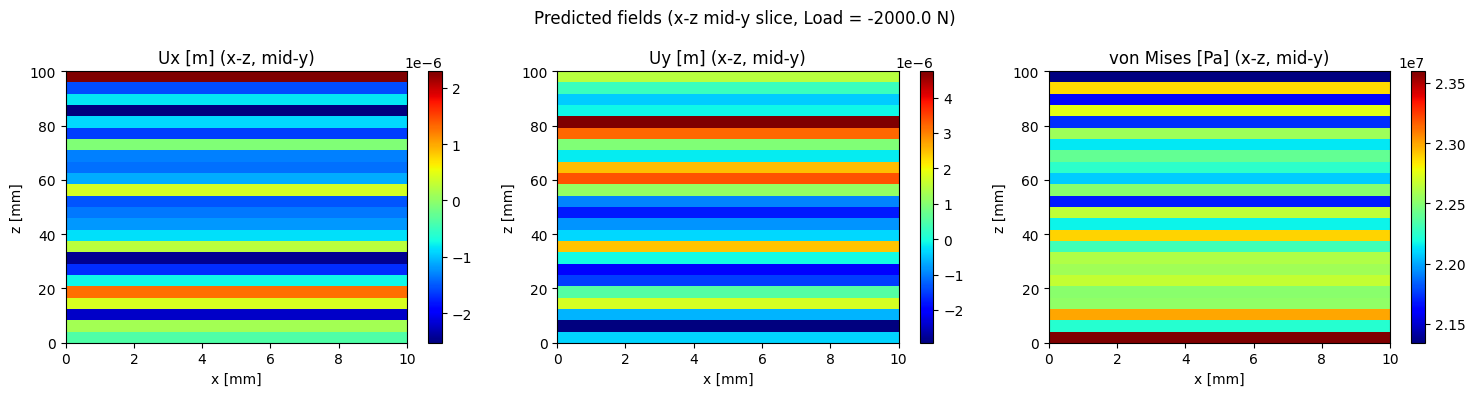

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 任意荷重ケースでの3D推論 ---

# 1. 入力と同じ形のマスクを作るために、どれか1つ既存ケースのVTUを基準にする
base_vtu = vtu_files[0]  # 形状は全ケース共通想定
pts_base, disp_base, mises_base = load_case(base_vtu)

# 2. 3Dグリッド座標は学習時と同じ Config の範囲を使用
nx, ny, nz = Config.nx, Config.ny, Config.nz

# Geometry / BC / Load のマスク生成
geo_mask  = np.ones((nx, ny, nz), dtype=np.float32)              # 全体1
fix_mask  = np.zeros_like(geo_mask, dtype=np.float32); fix_mask[:, :, 0]  = 1.0   # z=0 固定
load_mask = np.zeros_like(geo_mask, dtype=np.float32); load_mask[:, :, -1] = 1.0  # z=最大に荷重

# 3. 任意荷重値（N）を指定し、符号と絶対値を分離する ★変更点★
any_load_N = -2000.0  # ← マイナスの値を指定しても大丈夫になります

# 荷重の「符号」と「大きさ（絶対値）」を分離
load_sign = np.sign(any_load_N)       # プラスなら1.0, マイナスなら-1.0
load_magnitude = np.abs(any_load_N)   # 常に正の値にする

# モデルに入力するのは「正の大きさ」だけにする
load_value_norm = load_magnitude / Config.load_norm
val_channel = np.full_like(geo_mask, load_value_norm, dtype=np.float32)

# 4. 入力テンソルを作成 (1, nx, ny, nz, 4)
inp_np = np.stack([geo_mask, fix_mask, load_mask, val_channel], axis=-1)  # (nx, ny, nz, 4)
inp_torch = torch.from_numpy(inp_np).unsqueeze(0).to(Config.device)

# 5. 推論 (モデルは正の荷重だと思って計算する)
model.eval()
with torch.no_grad():
    pred = model(inp_torch)  # (1, nx, ny, nz, 4)

pred_np = pred.squeeze(0).cpu().numpy()  # (nx, ny, nz, 4)

# 6. 物理量に復元（変位だけ符号を適用する） ★変更点★
# 変位は荷重の向きに従うので、符号(load_sign)を掛ける
ux_pred_n = pred_np[..., 0] * load_sign
uy_pred_n = pred_np[..., 1] * load_sign
uz_pred_n = pred_np[..., 2] * load_sign

# 応力(Von Mises)はスカラー量(常に正)なので、符号は掛けない
mises_pred_n = pred_np[..., 3]

# スケールを物理単位に戻す
ux_pred = ux_pred_n * Config.scales['disp']
uy_pred = uy_pred_n * Config.scales['disp']
uz_pred = uz_pred_n * Config.scales['disp']
mises_pred = mises_pred_n * Config.scales['stress']

# print(f"Prediction done for load = {any_load_N} N")
# print(f"Max |Ux|: {np.max(np.abs(ux_pred)):.3e} m")
# print(f"Max |Uy|: {np.max(np.abs(uy_pred)):.3e} m")
# print(f"Max |Uz|: {np.max(np.abs(uz_pred)):.3e} m")
# print(f"Max von Mises: {np.max(mises_pred)/1e6:.3f} MPa")

print(f"Prediction done for load = {any_load_N} N")
print(f"Ux range: {np.min(ux_pred):.3e} ～ {np.max(ux_pred):.3e} m")
print(f"Uy range: {np.min(uy_pred):.3e} ～ {np.max(uy_pred):.3e} m")
print(f"Uz range: {np.min(uz_pred):.3e} ～ {np.max(uz_pred):.3e} m")
print(f"Max von Mises: {np.max(mises_pred)/1e6:.3f} MPa")


# 7. 代表スライスの簡易可視化
y_mid = ny // 2  # 梁高さ方向の中央スライス
x_min, x_max = Config.x_range
z_min, z_max = Config.z_range

ux_xz = ux_pred[:, y_mid, :]
uy_xz = uy_pred[:, y_mid, :]
mises_xz = mises_pred[:, y_mid, :]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Predicted fields (x-z mid-y slice, Load = {any_load_N} N)")

im0 = axes[0].imshow(ux_xz.T, origin='lower', cmap='jet', extent=[x_min, x_max, z_min, z_max], aspect='auto')
axes[0].set_title('Ux [m] (x-z, mid-y)')
axes[0].set_xlabel('x [mm]')
axes[0].set_ylabel('z [mm]')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(uy_xz.T, origin='lower', cmap='jet', extent=[x_min, x_max, z_min, z_max], aspect='auto')
axes[1].set_title('Uy [m] (x-z, mid-y)')
axes[1].set_xlabel('x [mm]')
axes[1].set_ylabel('z [mm]')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(mises_xz.T, origin='lower', cmap='jet', extent=[x_min, x_max, z_min, z_max], aspect='auto')
axes[2].set_title('von Mises [Pa] (x-z, mid-y)')
axes[2].set_xlabel('x [mm]')
axes[2].set_ylabel('z [mm]')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

学習データの確認

In [33]:
import pyvista as pv
import numpy as np

mesh = pv.read(vtu_files[11])  # 例として最初のケース
disp = mesh.point_data["Displacement"]  # (N,3)

print("Max |Ux| (FEM):", np.max(np.abs(disp[:, 0])))
print("Max |Uy| (FEM):", np.max(np.abs(disp[:, 1])))
print("Max |Uz| (FEM):", np.max(np.abs(disp[:, 2])))

Max |Ux| (FEM): 1.65189e-05
Max |Uy| (FEM): 1.75323e-05
Max |Uz| (FEM): 3.33167e-05


In [35]:
print("Uz range:", np.min(uz_pred), "to", np.max(uz_pred))

Uz range: -4.826239049434662e-05 to -2.6429262757301334e-05
